In [1]:
import pandas as pd  
import numpy as np  
from keras.models import Model  
from keras.layers import Input, Dense  
from keras.optimizers import Adam  
from sklearn.preprocessing import StandardScaler  
import matplotlib.pyplot as plt  

# Load datasets  
hpc_df = pd.read_csv('../data/processed/HPC_processed.csv')  
power_df = pd.read_csv('../data/processed/Power_processed.csv') 

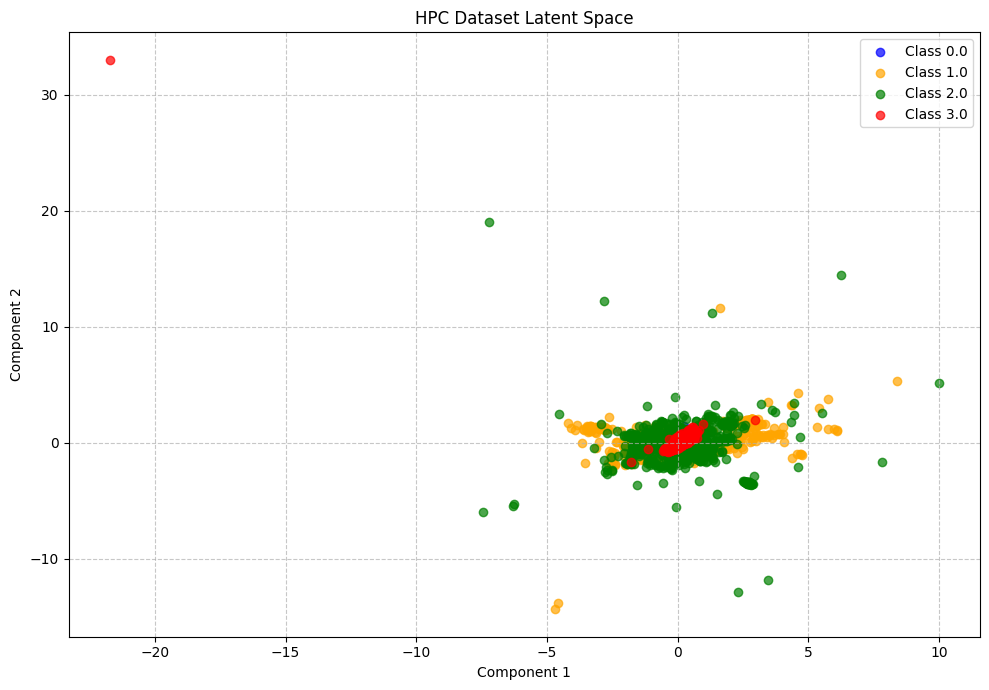

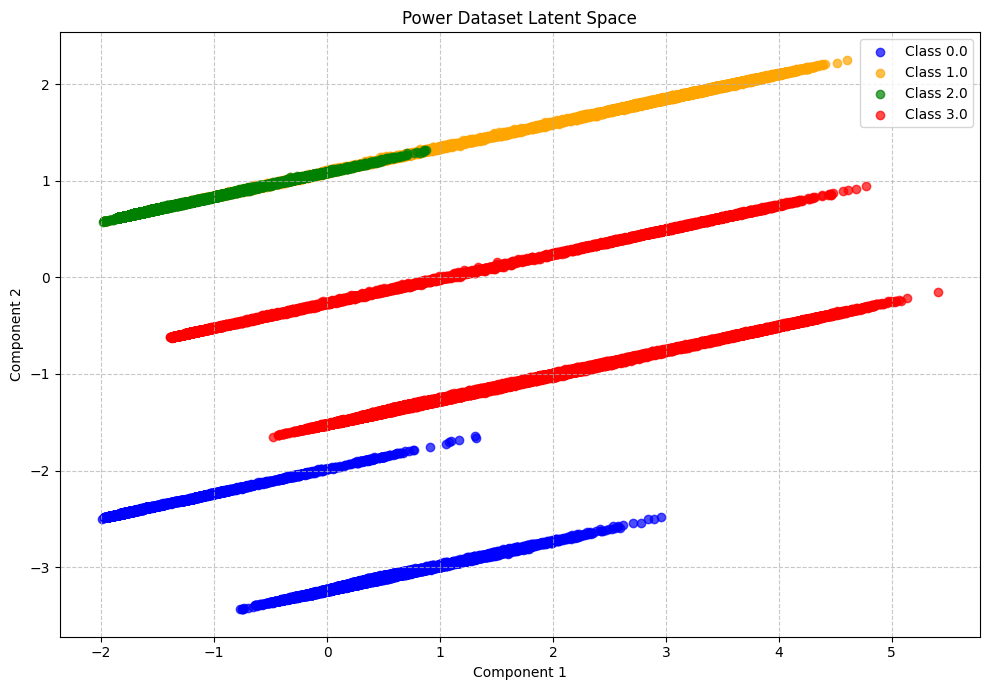

In [7]:
import matplotlib.pyplot as plt  
from sklearn.decomposition import PCA  
from sklearn.metrics import mean_squared_error  
import numpy as np  

# Drop non-feature columns  
X_hpc = hpc_df.drop(columns=['Scenario']).values  
X_power = power_df.drop(columns=['Attack-Group']).values  

# Scale independently  
scaler_hpc = StandardScaler()  
scaler_power = StandardScaler()  

X_hpc_scaled = scaler_hpc.fit_transform(X_hpc)  
X_power_scaled = scaler_power.fit_transform(X_power)  

# 1. Visualize latent representations in 2D using PCA  
# Vẽ lại từng color cho mỗi class trong code dưới đây
def plot_latent_space(latent_vectors, labels, title):  
    if latent_vectors.shape[1] > 2:  
        # Reduce dimensionality for plotting  
        reducer = PCA(n_components=2)  
        reduced = reducer.fit_transform(latent_vectors)  
    else:  
        reduced = latent_vectors  
    
    plt.figure(figsize=(10, 7))  
    
    # Định nghĩa bảng màu cụ thể cho từng class
    color_map = {
        0: 'blue', 
        1: 'orange', 
        2: 'green', 
        3: 'red'
    }
    
    # Vẽ từng class với màu riêng
    for class_label in np.unique(labels):
        # Tìm chỉ số của các điểm thuộc class này
        mask = (labels == class_label)
        
        plt.scatter(
            reduced[mask, 0], 
            reduced[mask, 1], 
            c=color_map.get(class_label, 'gray'),  # Dùng màu gray nếu class không có trong color_map
            label=f'Class {class_label}', 
            alpha=0.7
        )
    
    plt.title(title)  
    plt.xlabel("Component 1")  
    plt.ylabel("Component 2")  
    plt.grid(True, linestyle='--', alpha=0.7)  
    plt.legend()  # Thêm legend để hiển thị nhãn các class
    plt.tight_layout()
    plt.show()
    
labels_hpc = hpc_df['Scenario'].values
labels_power = power_df['Attack-Group'].values

# Plot latent spaces, nhớ truyền thêm nhãn cho từng tập dữ liệu
plot_latent_space(X_hpc_scaled, labels_hpc, "HPC Dataset Latent Space")  
plot_latent_space(X_power_scaled, labels_power, "Power Dataset Latent Space")  

In [9]:
# # plot widget data as same as above plot
# widget.plot(X_hpc_scaled, labels_hpc, "HPC Dataset Latent Space")
# widget.plot(X_power_scaled, labels_power, "Power Dataset Latent Space")
# 2. Train a simple autoencoder
def build_autoencoder(input_dim):  
    input_layer = Input(shape=(input_dim,))  
    encoded = Dense(64, activation='relu')(input_layer)  
    encoded = Dense(32, activation='relu')(encoded)  
    decoded = Dense(64, activation='relu')(encoded)  
    decoded = Dense(input_dim, activation='sigmoid')(decoded)  
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)  
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')  
    return autoencoder
# Train autoencoder on HPC dataset
autoencoder_hpc = build_autoencoder(X_hpc_scaled.shape[1])
history_hpc = autoencoder_hpc.fit(X_hpc_scaled, X_hpc_scaled, epochs=50, batch_size=32, validation_split=0.2)
# Train autoencoder on Power dataset
autoencoder_power = build_autoencoder(X_power_scaled.shape[1])
history_power = autoencoder_power.fit(X_power_scaled, X_power_scaled, epochs=50, batch_size=32, validation_split=0.2)
# 3. Visualize training loss
# def plot_training_loss(history, title):  
#     plt.plot(history.history['loss'], label='Train Loss')  
#     plt.plot(history.history['val_loss'], label='Validation Loss')  
#     plt.title(title)  
#     plt.xlabel('Epochs')  
#     plt.ylabel('Loss')  
#     plt.legend()  
#     plt.show()  
# plot_training_loss(history_hpc, "HPC Dataset Autoencoder Training Loss")
# plot_training_loss(history_power, "Power Dataset Autoencoder Training Loss")
# # 4. Evaluate reconstruction error
# def evaluate_reconstruction_error(autoencoder, X_scaled):  
#     reconstructed = autoencoder.predict(X_scaled)  
#     mse = mean_squared_error(X_scaled, reconstructed)  
#     return mse
# mse_hpc = evaluate_reconstruction_error(autoencoder_hpc, X_hpc_scaled)
# mse_power = evaluate_reconstruction_error(autoencoder_power, X_power_scaled)
# print(f"HPC Dataset Reconstruction Error (MSE): {mse_hpc}")
# print(f"Power Dataset Reconstruction Error (MSE): {mse_power}")
# # 5. Visualize reconstruction error distribution
# def plot_reconstruction_error_distribution(X_scaled, reconstructed):  
#     errors = np.mean(np.square(X_scaled - reconstructed), axis=1)  
#     plt.figure(figsize=(8, 6))  
#     plt.hist(errors, bins=50, alpha=0.7)  
#     plt.title("Reconstruction Error Distribution")  
#     plt.xlabel("Reconstruction Error (MSE)")  
#     plt.ylabel("Frequency")  
#     plt.grid(True)  
#     plt.show()
# reconstructed_hpc = autoencoder_hpc.predict(X_hpc_scaled)
# reconstructed_power = autoencoder_power.predict(X_power_scaled)
# plot_reconstruction_error_distribution(X_hpc_scaled, reconstructed_hpc)
# plot_reconstruction_error_distribution(X_power_scaled, reconstructed_power)

# # 6. Visualize latent space of the autoencoder
# def plot_latent_space_autoencoder(autoencoder, X_scaled, labels, title):  
#     encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)  
#     latent_vectors = encoder.predict(X_scaled)  
#     plot_latent_space(latent_vectors, labels, title)
# plot_latent_space_autoencoder(autoencoder_hpc, X_hpc_scaled, labels_hpc, "HPC Dataset Autoencoder Latent Space")
# plot_latent_space_autoencoder(autoencoder_power, X_power_scaled, labels_power, "Power Dataset Autoencoder Latent Space")
# 7. Visualize PCA of the latent space


Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5598 - val_loss: 3.0378
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3877 - val_loss: 2.9733
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3474 - val_loss: 2.9312
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3992 - val_loss: 2.9062
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4292 - val_loss: 2.8934
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3413 - val_loss: 2.8917
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3253 - val_loss: 2.8788
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3207 - val_loss: 2.8776
Epoch 9/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3142 - val_loss: 2.8660
Epoch 10/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3183 - val_loss: 2.8619
Epoch 11/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3099 - val_loss: 2.8561
Epoch 12/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


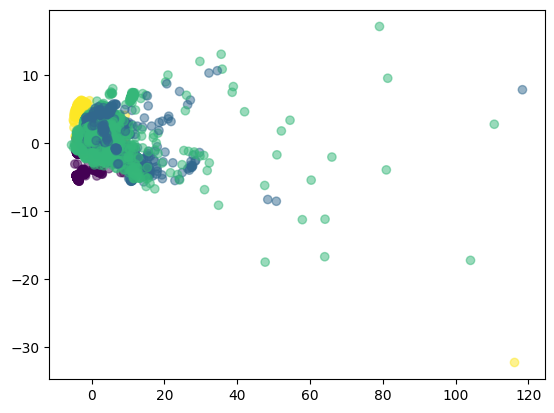

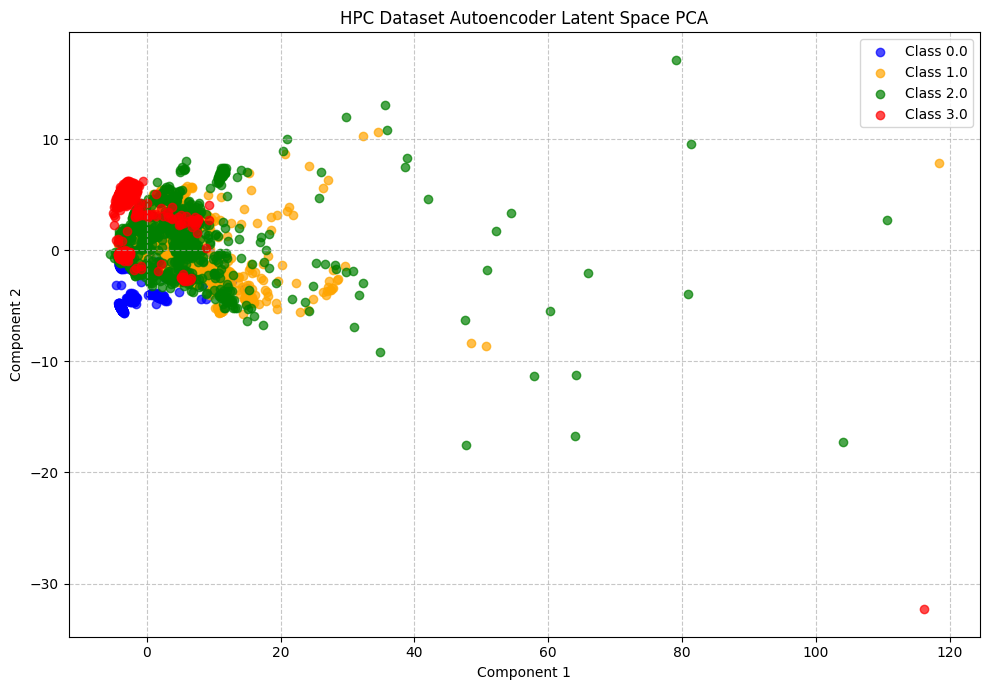

3604/3604 ━━━━━━━━━━━━━━━━━━━━ 3s 865us/step


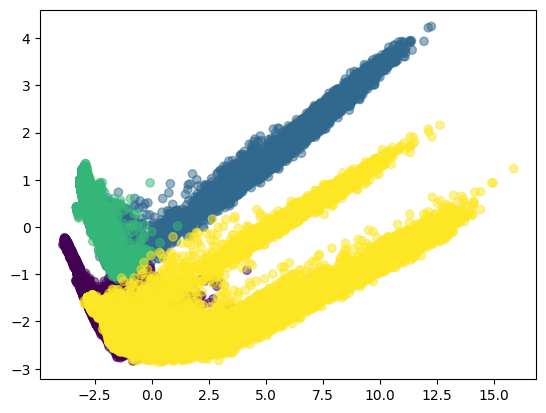

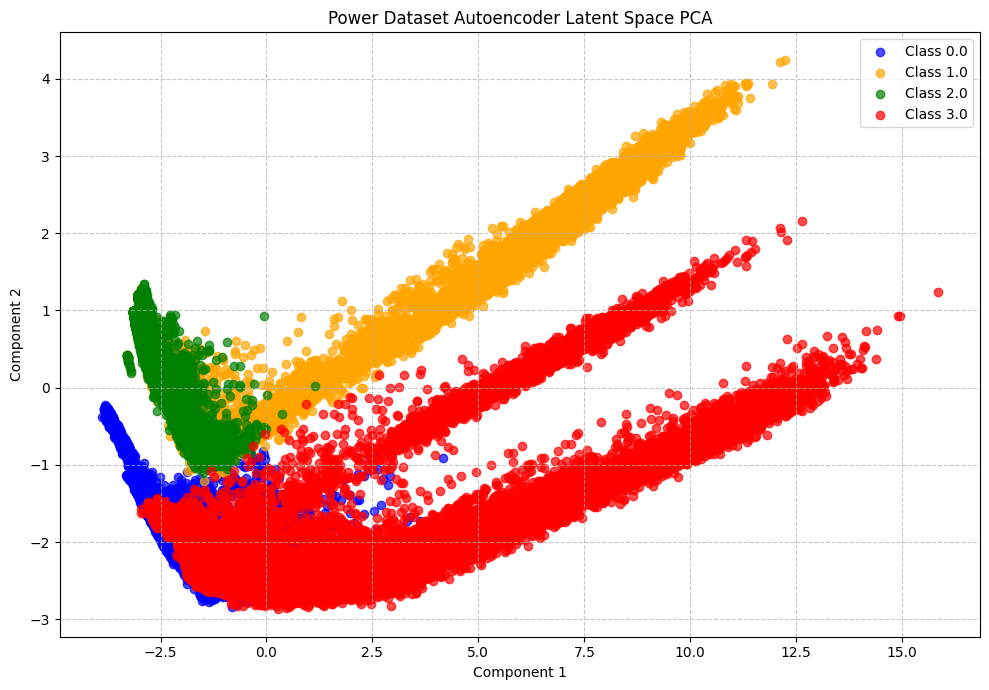

In [10]:
def plot_pca_latent_space(autoencoder, X_scaled, labels, title):  
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)  
    latent_vectors = encoder.predict(X_scaled)  
    
    # PCA reduction  
    pca = PCA(n_components=2)  
    reduced = pca.fit_transform(latent_vectors) 
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, alpha=0.5, cmap='viridis')  
    plt.figure(figsize=(10, 7))  
    
    # Định nghĩa bảng màu cụ thể cho từng class
    color_map = {
        0: 'blue', 
        1: 'orange', 
        2: 'green', 
        3: 'red'
    }
    
    # Vẽ từng class với màu riêng
    for class_label in np.unique(labels):
        # Tìm chỉ số của các điểm thuộc class này
        mask = (labels == class_label)
        
        plt.scatter(
            reduced[mask, 0], 
            reduced[mask, 1], 
            c=color_map.get(class_label, 'gray'),  # Dùng màu gray nếu class không có trong color_map
            label=f'Class {class_label}', 
            alpha=0.7
        )
    
    plt.title(title)  
    plt.xlabel("Component 1")  
    plt.ylabel("Component 2")  
    plt.grid(True, linestyle='--', alpha=0.7)  
    plt.legend()  # Thêm legend để hiển thị nhãn các class
    plt.tight_layout()
    plt.show()
plot_pca_latent_space(autoencoder_hpc, X_hpc_scaled, labels_hpc, "HPC Dataset Autoencoder Latent Space PCA")
plot_pca_latent_space(autoencoder_power, X_power_scaled, labels_power, "Power Dataset Autoencoder Latent Space PCA")

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3604/3604 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


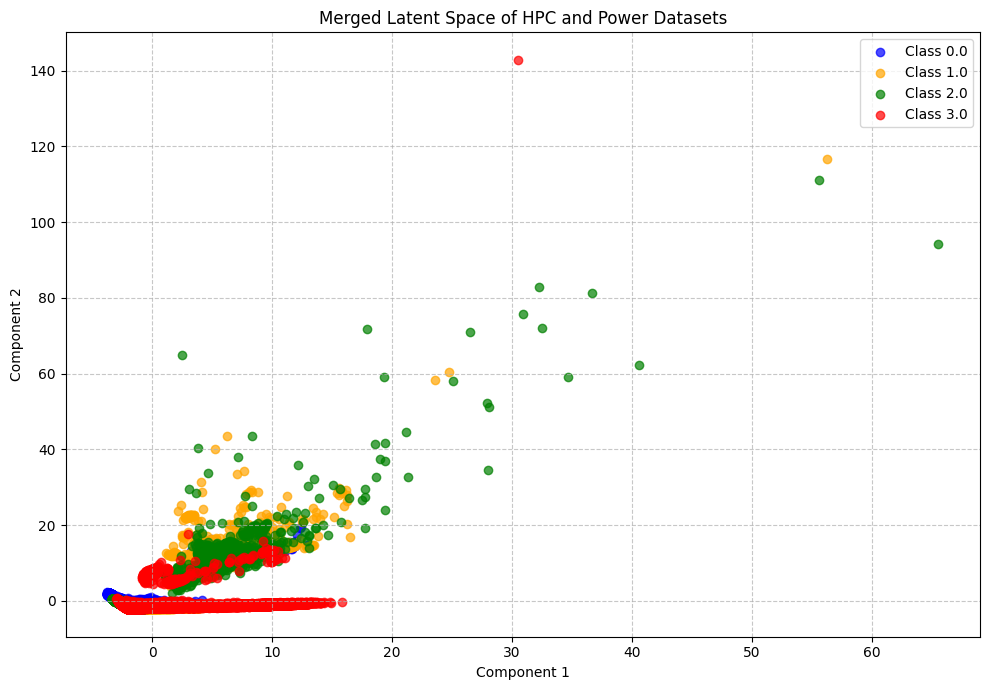

In [11]:
# help me merge the two encoded data and plot them
def plot_merged_latent_space(autoencoder1, X1_scaled, labels1, autoencoder2, X2_scaled, labels2, title):
    encoder1 = Model(inputs=autoencoder1.input, outputs=autoencoder1.layers[2].output)
    latent_vectors1 = encoder1.predict(X1_scaled)

    encoder2 = Model(inputs=autoencoder2.input, outputs=autoencoder2.layers[2].output)
    latent_vectors2 = encoder2.predict(X2_scaled)

    # Merge the latent vectors and labels
    merged_latent = np.concatenate([latent_vectors1, latent_vectors2], axis=0)
    merged_labels = np.concatenate([labels1, labels2], axis=0)

    # Plot the merged latent space
    plot_latent_space(merged_latent, merged_labels, title)

plot_merged_latent_space(autoencoder_hpc, X_hpc_scaled, labels_hpc, autoencoder_power, X_power_scaled, labels_power, "Merged Latent Space of HPC and Power Datasets")